In [1]:
# ============= imports =============
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
from Model_architectures import Unet
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import copy
import sewar
from torchvision.utils import save_image

/home/k4agrawal/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ============= torch cuda =============
if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.empty_cache()
else:
    device = 'cpu'

In [3]:
def normalize_img(img):
    norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    norm_image = norm_image.astype(np.uint8)
    return norm_image

def get_metrics(orig_img,pred_img):
    
    #converting to numpy array
    orig_img = orig_img.permute(1,2,0).detach().cpu().numpy()
    pred_img = pred_img.permute(1,2,0).detach().cpu().numpy()
    
    #normalization
    orig_img = normalize_img(orig_img)
    pred_img = normalize_img(pred_img)
    
    #psnr
    psnr_score = sewar.psnr(pred_img,orig_img)
    #ssim
    ssim_score = sewar.ssim(pred_img,orig_img)[0]
    #uqi
    uqi_score = sewar.uqi(pred_img,orig_img)
    
    return psnr_score,ssim_score,uqi_score

In [4]:
def motion_blur_horizontal(img_path,kernel_size):
    img = cv2.imread(img_path)

    kernel_h = np.zeros((kernel_size, kernel_size))
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel_h /= kernel_size

    horizontal_mb = cv2.filter2D(img, -1, kernel_h)
    horizontal_mb = cv2.cvtColor(horizontal_mb, cv2.COLOR_RGB2BGR)
    return horizontal_mb
    
def motion_blur_vertical(img_path,kernel_size):
    img = cv2.imread(img_path)
    kernel_v = np.zeros((kernel_size, kernel_size))
    kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
    kernel_v /= kernel_size
    vertical_mb = cv2.filter2D(img, -1, kernel_v)
    vertical_mb = cv2.cvtColor(vertical_mb, cv2.COLOR_RGB2BGR)
    return vertical_mb
    
def gaussian_blur(img_path,k_size):
    img = cv2.imread(img_path)
    img = cv2.GaussianBlur(img,(k_size,k_size),0)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img
    
def avg_blur(img_path,k_size):
    img = cv2.imread(img_path)
    img = cv2.blur(img, (k_size,k_size))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img
        
def getBlurredOutput(img_path):
    p = torch.rand(1)
    k_size = 15
        
    if p<=0.25:
        return motion_blur_vertical(img_path,k_size)
    if p<=0.5:
        return motion_blur_horizontal(img_path,k_size)
    if p<=0.75:
        return avg_blur(img_path,k_size)
    else:
        return gaussian_blur(img_path,k_size)

In [5]:
def image_loader(imgPath):
    '''
        Function to return image tensor
        :params imgPath: path to input image
        :type imgPath: str
        :return: dictionary with groundTruth image and blurred image
    '''
    image = Image.open(imgPath)
    blurredImage = getBlurredOutput(imgPath)
    
    imageTransform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256))
    ])

    image = imageTransform(image)
    blurredImage = imageTransform(blurredImage)
    return {'image': image.to(device), 'inputImg': blurredImage.to(device)}

In [6]:
def plot_outputs(gtImg, blurImg, beforeTTT, afterTTT):
    fig,axs = plt.subplots(1,3, figsize=(20, 20))
    axs[0].imshow(blurImg.permute(1,2,0))
    axs[0].set_xlabel('Input Blur Image', fontsize=15)
    axs[1].imshow(beforeTTT.permute(1,2,0))
    axs[1].set_xlabel('Without TTT', fontsize=15)
    axs[2].imshow(afterTTT.permute(1,2,0))
    axs[2].set_xlabel('After TTT', fontsize=15)
    return axs

In [7]:
imageDict = image_loader('VOCdevkit/VOC2012/JPEGImages/2008_008772.jpg')

In [8]:
encoder = Unet.Encoder(in_channels=3).to(device)
decoder = Unet.Decoder().to(device)
classifier = Unet.Classifier().to(device)

encoder_new = copy.deepcopy(encoder).to(device)
decoder_new = decoder
classifier_new = copy.deepcopy(classifier).to(device)

In [9]:
# =========== Load state dict for both encoder, and encoder new ===========
encoder.load_state_dict(torch.load('./Unet_all_blur/encoder.pth'))
decoder.load_state_dict(torch.load('./Unet_all_blur/decoder.pth'))
classifier.load_state_dict(torch.load('./Unet_all_blur/classifier.pth'))

test_time_checkpoint = torch.load('./Unet_all_blur/continuous_ttt_20.ckpt')
encoder_new.load_state_dict(test_time_checkpoint['encoder'])
decoder_new.load_state_dict(test_time_checkpoint['decoder'])
classifier_new.load_state_dict(test_time_checkpoint['classifier'])

<All keys matched successfully>

Without Test Time Training
psnr: 14.5041, ssim: 0.3989, uqi: 0.6873


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


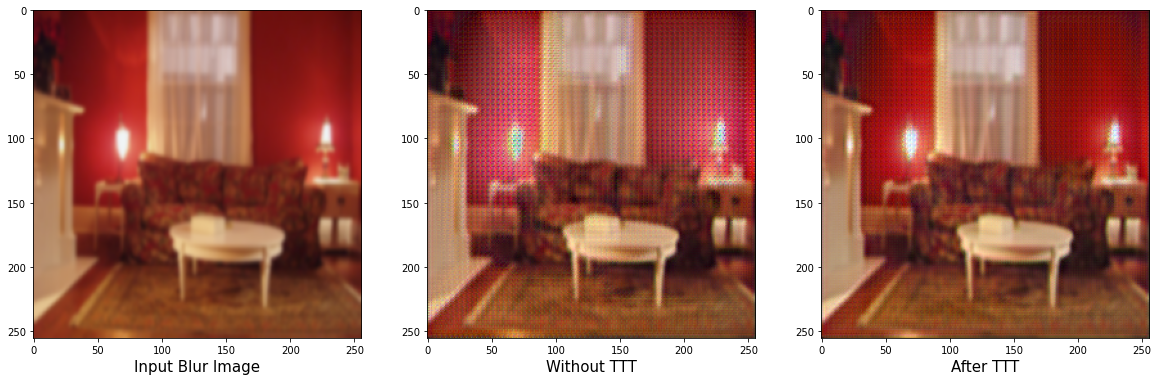

With Test Time Training
psnr: 21.5010, ssim: 0.5679, uqi: 0.8720


In [10]:
encoder.eval()
decoder.eval()
classifier.eval()

with torch.no_grad():
    x, skip_connections = encoder(imageDict['inputImg'].unsqueeze(0))
    pred_img_beforeTTT = decoder(x, skip_connections)
    save_image(pred_img_beforeTTT.squeeze(), 'beforeTTT.png')
    psnr, ssim, uqi = get_metrics(imageDict['image'], pred_img_beforeTTT.squeeze())
    print('Without Test Time Training')
    print('psnr: {:.4f}, ssim: {:.4f}, uqi: {:.4f}'.format(psnr, ssim, uqi))

encoder_new.eval()
decoder_new.eval()
classifier_new.eval()
with torch.no_grad():
    x, skip_connections = encoder_new(imageDict['inputImg'].unsqueeze(0))
    pred_img_afterTTT = decoder_new(x, skip_connections)
    save_image(pred_img_afterTTT.squeeze(), 'afterTTT.png')
    psnr, ssim, uqi = get_metrics(imageDict['image'], pred_img_afterTTT.squeeze())
    ax = plot_outputs(imageDict['image'].cpu(), imageDict['inputImg'].cpu(), pred_img_beforeTTT.squeeze().cpu(), pred_img_afterTTT.squeeze().cpu())
    plt.show()
    print('With Test Time Training')
    print('psnr: {:.4f}, ssim: {:.4f}, uqi: {:.4f}'.format(psnr, ssim, uqi))